## Comparing MPPCA denoised and raw diffusion data
### Does denoising improve within subject/scanner reproducibility?

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import xarray as xr
import pingouin as pg

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
import plotly.express as px
from scipy.stats import linregress
import plotly.graph_objects as go

import glob
import re

sns.set_theme()
sns.set_context("talk")

In [2]:
# some useful dictonaries and lists
vendor_dict = {"TRI": "Siemens", "PRI": "Siemens", "ING": "Philips", "ACH": "Philips", "GEM": "GE"}

scanner_dict = {"NOT1ACH": "Philips Achieva",
                "NOT2ING": "Philips Ingenia", 
                "NOT3GEM": "GE MR750", 
                "OXF1PRI": "Siemens Prisma 32",
                "OXF2PRI": "Siemens Prisma 64",
                "OXF3TRI": "Siemens Trio"}

scanner_code_dict = {"NOT1ACH": "Ach",
                        "NOT2ING": "Ing", 
                        "NOT3GEM": "750", 
                        "OXF1PRI": "Pri32",
                        "OXF2PRI": "Pri64",
                        "OXF3TRI": "Trio"}

basic_info_hdrs = ['session', 'scanner_name', 'vendor', 'scanner_code', 'denoised',
             'scanner_type', 'scanner_typeloc', 'scan_session_num', 'scan_session', 'subject']

info_hdrs = basic_info_hdrs

##### IQM headers
# the dMRI IQMs - excluding the higher shell QC measures (as GE is single-shell)
# dmri_iqm_hdrs = ['dMRI_eddy_outlier', 'dMRI_qc_cnr_avg_1', 'dMRI_qc_cnr_avg_2',
#        'dMRI_qc_cnr_std_1', 'dMRI_qc_cnr_std_2',
#        'dMRI_qc_outliers_b_1',
#        'dMRI_qc_outliers_pe_1', 'dMRI_qc_mot_abs', 'dMRI_qc_mot_rel',
#        'dMRI_qc_outliers_tot']

dmri_iqm_hdrs = [#'dMRI_eddy_outlier', 
                 'dMRI_qc_cnr_avg_1', 'dMRI_qc_cnr_avg_2',
       'dMRI_qc_cnr_std_1', 'dMRI_qc_cnr_std_2',
    'dMRI_qc_mot_abs', 'dMRI_qc_mot_rel',
       #'dMRI_qc_outliers_b_1',
       #'dMRI_qc_outliers_pe_1',
       #'dMRI_qc_outliers_tot'
                ]


all_dmri_iqm_hdrs = ['dMRI_eddy_outlier', 'dMRI_qc_cnr_avg_1', 'dMRI_qc_cnr_avg_2',
       'dMRI_qc_cnr_avg_3', 'dMRI_qc_cnr_std_1', 'dMRI_qc_cnr_std_2',
       'dMRI_qc_cnr_std_3', 'dMRI_qc_outliers_b_1', 'dMRI_qc_outliers_b_2',
       'dMRI_qc_outliers_pe_1', 'dMRI_qc_mot_abs', 'dMRI_qc_mot_rel',
       'dMRI_qc_outliers_tot']

# subjects used here - those with within-scanner repeats
reptlist = [["13192", "OXF1PRI"],
            ["14229", "OXF2PRI"],
            ["14230", "OXF3TRI"],
            ["14482", "NOT1ACH"]]


In [3]:
# FacetGrid heatmap function
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot_table(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs)
    
def get_tri_annots(df, side='upper'):
    if side == 'upper':
        mask = np.triu(np.ones_like(df, dtype=bool), 1)
    elif side == 'lower':
        mask = np.tril(np.ones_like(df, dtype=bool), 1)
    
    labels = df.values.copy().round(3)
    labels[~mask] = np.nan
    annotations = labels.astype(str)
    annotations[np.isnan(labels)] = ""
    return annotations

def get_measure_type(measure_names, IDP=True):
    measure_type = []
    
    if IDP == True:
        for l in measure_names:
            if 'dMRI' in l:
                measure_type = measure_type + [re.search('dMRI_(.*)_[0-9]+', l).group(1)]
            elif 'T1_SIENAX' in l:
                measure_type = measure_type + ['T1_SIENAX']
            elif 'T1_GM_parcellation' in l:
                measure_type = measure_type + ['T1_GM_parcellation']
            elif 'T1_FIRST' in l:
                measure_type = measure_type + ['T1_FIRST']
            elif 'T2_FLAIR' in l:
                measure_type = measure_type + ['T2_FLAIR']
            elif 'SWI_T2star' in l:
                measure_type = measure_type + ['SWI_T2star']    
            elif 'rfMRI_d' in l:
                measure_type = measure_type + [re.search('rfMRI_d(.*)_[0-9]+', l).group(1)]
            else:
                measure_type = measure_type + ["other"]
    elif IDP == False:
        for l in measure_names:
            if 'dMRI' in l:        
                measure_type = measure_type + ['dMRI']
            elif 'T1w' in l:
                measure_type = measure_type + ['T1'] 
            elif 'T2' in l:
                measure_type = measure_type + ['T2']
            elif 'SWI' in l:
                measure_type = measure_type + ['SWI'] 
            elif 'fmri' in l:
                measure_type = measure_type + ['fMRI']
            elif 'rfMRI' in l:
                measure_type = measure_type + ['fMRI']
    return measure_type


## Build main dataframe

#### Load UKBB pipeline data

In [4]:
studydir='/Users/shaunwarrington/OneDrive - The University of Nottingham (1)/Deliverables/Papers/NHarmony'
fig_out = f'{studydir}/pyfigs'

# Load IDP headers
hdrs = np.loadtxt(f'{studydir}/data/headers.txt', 'str')
hdrs = np.concatenate([['session'], hdrs])
hdrs = [x for x in hdrs if 'dMRI' in x] # not using MIST
# hdrs = [x for x in hdrs if 'eddy' not in x] # not using MIST

# Load IDPs - load in a structured (for-loop) way to ensure consistent subject and IDP order
df = pd.DataFrame()
session_list = []
for sub, scanner in reptlist: 
    for denoise_opt in ['', '_denoise', '_denoise_post_eddy']:
        for i in range(1, 7):
            # first eddy_outliers, then TBSS, then xtract
            subdir = f'{studydir}/data/denoise_dmri_IDPs/{sub}_{scanner}00{i}{denoise_opt}'
            idp_files = [f'{subdir}_bb_IDP_diff_eddy_outliers.txt', 
                         f'{subdir}_bb_IDP_diff_TBSS.txt', 
                         f'{subdir}_bb_IDP_diff_xtract.txt']

            tempdf = [pd.read_csv(f, sep=" ", index_col=None, header=None) for f in idp_files]
            tempdf = pd.concat(tempdf, axis=1)
            session_list.append(f'{sub}_{scanner}00{i}{denoise_opt}')
            
            df = pd.concat((df, tempdf), axis=0)

df.columns = hdrs
df.insert(0, "session", session_list)
df.reset_index(drop=True, inplace=True)

# Load IQMs
tempdf = pd.DataFrame()
for sub, scanner in reptlist: 
    for denoise_opt in ['', '_denoise']:
        for i in range(1, 7):
            subdir = f'{studydir}/data/denoise_dmri_IDPs/{sub}_{scanner}00{i}{denoise_opt}'
            f = f'{subdir}_eddyqc.txt'
            tempdf = pd.concat((tempdf, pd.read_csv(f, sep=" ", index_col=None)), axis=0)

tempdf.drop("modality", axis=1, inplace=True)
tempdf = tempdf.add_prefix('dMRI_')
tempdf = tempdf.rename(columns={'dMRI_session': 'session'})
df = pd.merge(df, tempdf, on="session", how="left")

print(f'{df.shape[0]} sessions') 

72 sessions


#### Get the header descriptions

In [5]:
hdr_descriptions = pd.read_csv(f'{studydir}/data/hdr_descriptions.txt', sep="\r\t", names=['desc'])
hdr_descriptions["hdr"] = np.loadtxt(f'{studydir}/data/headers.txt', 'str')
                                     
hdr_descriptions = hdr_descriptions[hdr_descriptions["hdr"].str.contains("tfMRI")==False]
hdr_descriptions = hdr_descriptions[hdr_descriptions["hdr"].str.contains("mist")==False]

def hdr_desc(hdr):
    try:
        desc = hdr_descriptions.loc[hdr_descriptions.hdr == hdr, 'desc'].values[0]
    except:
        desc = hdr
    return desc


/var/folders/z6/5_74m36111v5lyv08dzq7zqc0000gs/T/ipykernel_6792/1054213702.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  hdr_descriptions = pd.read_csv(f'{studydir}/data/hdr_descriptions.txt', sep="\r\t", names=['desc'])


#### Add session info columns

In [6]:
sublist = [t.split('_')[0] for t in df.session.values]
scan_session = [t.split('_')[1] for t in df.session.values]
scan_session_num = [t[-3:] for t in scan_session]
scanner_typeloc = [t.split('00')[0] for t in scan_session]
scanner_type = [t[-3:] for t in scanner_typeloc]

# df.insert(1, 'denoised', np.where(df['session'].str.endswith('_denoise'), 'denoised', 'raw'))
df.insert(1, 'denoised', df['session'])
df.loc[df['denoised'].str.endswith('_denoise'), 'denoised'] = 'denoised'
df.loc[df['denoised'].str.endswith('_denoise_post_eddy'), 'denoised'] = 'denoised_post_eddy'
df.loc[~df['denoised'].str.contains('denoise'), 'denoised'] = 'raw'

df.insert(1, 'subject', sublist)
df.insert(1, 'scan_session', scan_session)
df.insert(1, 'scan_session_num', scan_session_num)
df.insert(1, 'scanner_typeloc', scanner_typeloc)
df.insert(1, 'scanner_type', scanner_type)
df.insert(1, 'vendor', df['scanner_type'].map(vendor_dict))
df.insert(1, 'scanner_name', df['scanner_typeloc'].map(scanner_dict))
df.insert(1, 'scanner_code', df['scanner_typeloc'].map(scanner_code_dict))

df.columns = df.columns.str.strip()

df.head(12)

,session,scanner_code,scanner_name,vendor,scanner_type,scanner_typeloc,scan_session_num,scan_session,subject,denoised,...,dMRI_qc_cnr_avg_3,dMRI_qc_cnr_std_1,dMRI_qc_cnr_std_2,dMRI_qc_cnr_std_3,dMRI_qc_outliers_b_1,dMRI_qc_outliers_b_2,dMRI_qc_outliers_pe_1,dMRI_qc_mot_abs,dMRI_qc_mot_rel,dMRI_qc_outliers_tot
0,13192_OXF1PRI001,Pri32,Siemens Prisma 32,Siemens,PRI,OXF1PRI,001,OXF1PRI001,13192,raw,...,1.94,22.629999,1.31,1.23,0.777778,0.055556,0.396825,0.94,0.25,0.416667
1,13192_OXF1PRI002,Pri32,Siemens Prisma 32,Siemens,PRI,OXF1PRI,002,OXF1PRI002,13192,raw,...,1.94,26.709999,1.32,1.23,1.000000,0.000000,0.476190,0.29,0.22,0.500000
2,13192_OXF1PRI003,Pri32,Siemens Prisma 32,Siemens,PRI,OXF1PRI,003,OXF1PRI003,13192,raw,...,1.97,23.180000,1.31,1.25,1.083333,0.027778,0.529101,0.38,0.21,0.555556
3,13192_OXF1PRI004,Pri32,Siemens Prisma 32,Siemens,PRI,OXF1PRI,004,OXF1PRI004,13192,raw,...,1.86,22.840000,1.28,1.20,0.500000,0.000000,0.238095,0.32,0.25,0.250000
4,13192_OXF1PRI005,Pri32,Siemens Prisma 32,Siemens,PRI,OXF1PRI,005,OXF1PRI005,13192,raw,...,2.02,26.719999,1.36,1.28,0.694444,0.000000,0.330688,0.36,0.21,0.347222
5,13192_OXF1PRI006,Pri32,Siemens Prisma 32,Siemens,PRI,OXF1PRI,006,OXF1PRI006,13192,raw,...,1.82,24.660000,1.20,1.14,0.944444,0.027778,0.462963,0.33,0.22,0.486111
6,13192_OXF1PRI001_denoise,Pri32,Siemens Prisma 32,Siemens,PRI,OXF1PRI,001,OXF1PRI001,13192,denoised,...,3.81,29.379999,2.12,2.42,0.944444,0.000000,0.449735,0.95,0.21,0.472222
7,13192_OXF1PRI002_denoise,Pri32,Siemens Prisma 32,Siemens,PRI,OXF1PRI,002,OXF1PRI002,13192,denoised,...,3.99,37.270000,2.40,2.52,1.194444,0.000000,0.568783,0.28,0.20,0.597222
8,13192_OXF1PRI003_denoise,Pri32,Siemens Prisma 32,Siemens,PRI,OXF1PRI,003,OXF1PRI003,13192,denoised,...,4.00,31.620001,2.23,2.54,1.222222,0.000000,0.582011,0.37,0.19,0.611111
9,13192_OXF1PRI004_denoise,Pri32,Siemens Prisma 32,Siemens,PRI,OXF1PRI,004,OXF1PRI004,13192,denoised,...,3.33,29.750000,2.10,2.13,0.666667,0.000000,0.317460,0.30,0.23,0.333333


### Create before/after denoising dataframes

In [7]:
df_raw = df[df.denoised == 'raw']
df_denoised = df[df.denoised == 'denoised']
df_denoised_post_eddy = df[df.denoised == 'denoised_post_eddy']

print(f'{df_raw.shape[0]} raw sessions') 
df_raw.reset_index(drop=True, inplace=True)

print(f'{df_denoised.shape[0]} denoised sessions') 
df_denoised.reset_index(drop=True, inplace=True)

print(f'{df_denoised_post_eddy.shape[0]} denoised (post eddy) sessions') 
df_denoised_post_eddy.reset_index(drop=True, inplace=True)

24 raw sessions
24 denoised sessions
24 denoised (post eddy) sessions


#### Useful main data (df) lists

In [8]:
# subject, vendor and scanner lists
sub_list = df.subject.unique()
ven_list = df.vendor.unique()
scanner_typeloc_list = df.scanner_typeloc.unique()
scanner_type_list = df.scanner_type.unique()

print(f'{len(sub_list)} subjects')
print(f'{len(ven_list)} vendors')
print(f'{len(scanner_typeloc_list)} scanners')
print(f'{len(scanner_type_list)} scanner types')


4 subjects
2 vendors
4 scanners
3 scanner types


### Plot IQM correlation matrices

In [9]:
tempdf = df[['subject'] + ['scanner_code'] + ['denoised'] + dmri_iqm_hdrs + ['dMRI_qc_cnr_avg_2', 'dMRI_qc_cnr_std_2', 'dMRI_qc_cnr_avg_3', 'dMRI_qc_cnr_std_3']]
tempdf = pd.melt(tempdf, id_vars=['subject', 'scanner_code', 'denoised'], value_vars=dmri_iqm_hdrs + ['dMRI_qc_cnr_avg_2', 'dMRI_qc_cnr_std_2', 'dMRI_qc_cnr_avg_3', 'dMRI_qc_cnr_std_3'])
temp = tempdf.copy()
temp.scanner_code = "All scanners"
tempdf = pd.concat((tempdf, temp), axis=0)


tempdf.replace('dMRI_', '', regex=True, inplace=True)
tempdf.replace('_', ' ', regex=True, inplace=True)
tempdf.replace('qc ', '', regex=True, inplace=True)
tempdf.replace('cnr avg 1', 'SNR', regex=True, inplace=True)
tempdf.replace('cnr avg 2', 'CNR b1k', regex=True, inplace=True)
tempdf.replace('cnr avg 3', 'CNR b2k', regex=True, inplace=True)
tempdf.replace('cnr std 1', 'Standard deviation\nof SNR', regex=True, inplace=True)
tempdf.replace('cnr std 2', 'Standard deviation\nof CNR b1k', regex=True, inplace=True)
tempdf.replace('cnr std 3', 'Standard deviation\nof CNR b2k', regex=True, inplace=True)

tempdf = tempdf[tempdf.variable != "mot rel"]
tempdf = tempdf[tempdf.variable != "mot abs"]


tempdf[tempdf.variable == 'cnr std 3']

,subject,scanner_code,denoised,variable,value


In [10]:
dmri_iqm_hdrs

['dMRI_qc_cnr_avg_1',
 'dMRI_qc_cnr_avg_2',
 'dMRI_qc_cnr_std_1',
 'dMRI_qc_cnr_std_2',
 'dMRI_qc_mot_abs',
 'dMRI_qc_mot_rel']

/Users/shaunwarrington/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/Users/shaunwarrington/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


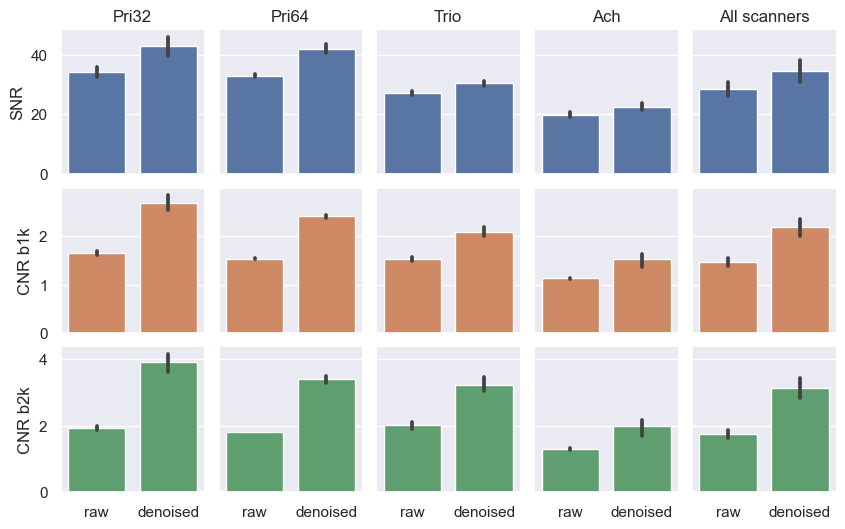

In [11]:
# tempdf = df[['subject'] + ['scanner_code'] + ['denoised'] + dmri_iqm_hdrs]
# tempdf = pd.melt(tempdf, id_vars=['subject', 'scanner_code', 'denoised'], value_vars=dmri_iqm_hdrs)

tempdf = df[['subject', 'scanner_code', 'denoised', 'dMRI_qc_cnr_avg_1', 'dMRI_qc_cnr_avg_2', 'dMRI_qc_cnr_avg_3']]
tempdf = pd.melt(tempdf, id_vars=['subject', 'scanner_code', 'denoised'], value_vars=['dMRI_qc_cnr_avg_1', 'dMRI_qc_cnr_avg_2', 'dMRI_qc_cnr_avg_3'])


temp = tempdf.copy()
temp.scanner_code = "All scanners"
tempdf = pd.concat((tempdf, temp), axis=0)

tempdf.replace('dMRI_', '', regex=True, inplace=True)
tempdf.replace('_', ' ', regex=True, inplace=True)
tempdf.replace('qc ', '', regex=True, inplace=True)
tempdf.replace('cnr avg 1', 'SNR', regex=True, inplace=True)
tempdf.replace('cnr avg 2', 'CNR b1k', regex=True, inplace=True)
tempdf.replace('cnr avg 3', 'CNR b2k', regex=True, inplace=True)
# tempdf.replace('cnr std 1', 'Standard deviation\nof SNR', regex=True, inplace=True)
# tempdf.replace('cnr std 2', 'Standard deviation\nof CNR b1k', regex=True, inplace=True)
# tempdf.replace('cnr std 3', 'Standard deviation\nof CNR b2k', regex=True, inplace=True)

tempdf = tempdf[tempdf.variable != "mot rel"]
tempdf = tempdf[tempdf.variable != "mot abs"]

sns.set(font_scale=1)
g = sns.FacetGrid(tempdf, row="variable", col='scanner_code',
                  height=2, aspect=1, hue='variable', sharey='row', 
                  gridspec_kws={"hspace": 0.1, "wspace": 0.1})#, margin_titles=True)
g.map(sns.barplot, 'denoised', 'value', order=['raw', 'denoised'])

# g.set_ylabels('')
g.set_xlabels('')
# g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

for i, ax_row in enumerate(g.axes):
    for j, ax_col in enumerate(ax_row):
        if i == 0:
            ax_col.set_title(tempdf.scanner_code.unique()[j])
        else:
            ax_col.set_title('')
        if j == 0:
            ax_col.set_ylabel(tempdf.variable.unique()[i])
        else:
            ax_col.set_ylabel('')

plt.show()

## IDP CoV before vs. after denoising 

In [12]:
def get_stats(df):
    mn = df.mean(axis=0).abs()
    std = df.std(axis=0).abs()
    med = df.median(axis=0).abs()
    mad = (df - df.mean()).abs().mean()
    mad_med = mad/med
    cv = std/mn
    return mn, med, mad, cv, mad_med

def plot_man(df, title):
    fig = plt.figure(figsize=(16, 4))

    with sns.axes_style("dark"):
        g = sns.scatterplot(data=df, y="value", x="IDP", hue="IDP_type")
        g.set_xticklabels("");
        g.set_ylabel("variation");
        g.set_title(title);
        g.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, frameon=False)
        g.axhline(0, linewidth=3, color='w', linestyle="--")

def plot_reldiff(raw, denoised):
    f = plt.figure(figsize=(16, 4))
    gs = f.add_gridspec(1, 2, width_ratios=[1, 4])

    ax = f.add_subplot(gs[0, 0])
    ax.axis('equal')
    ax.set_aspect('equal')
    g = sns.scatterplot(x=raw["value"].values, y=denoised["value"].values, 
                hue=denoised["IDP_type"].values, legend=False)
    g.set_xlabel("raw variability")
    g.set_ylabel("denoised variability")

    xlim = g.get_xlim()
    ylim = g.get_ylim()
    line = mlines.Line2D([-100, 100], [-100, 100], color='red')
    g.add_line(line)
    g.set_xlim(xlim[0], xlim[1])
    g.set_ylim(ylim[0], ylim[1])
    
    # difference
    diff = raw.copy()
    diff["relative difference"] = (raw["value"].values-denoised["value"].values)/raw["value"].values
    with sns.axes_style("dark"):
        ax = f.add_subplot(gs[0, 1])
        g = sns.scatterplot(data=diff, y="relative difference", x="IDP", hue="IDP_type")
        g.set_xticklabels("");
        g.legend(loc='upper right', bbox_to_anchor= (1.25,1), fontsize=10, frameon=False)
        g.axhline(0, linewidth=3, color='w', linestyle="--")
        
    plt.tight_layout()
    return diff

#### IDP-wise variance in raw and denoised

In [13]:
# plot IDP-wise average before vs after denoising

# idp_hdrs = list(df_denoise.filter(regex='dMRI_xtract|dMRI_TBSS').columns.values)
# idp_hdrs = list(df.filter(regex='dMRI_TBSS').columns.values)
idp_hdrs = list(df.filter(regex='dMRI_TBSS_FA|dMRI_TBSS_MD').columns.values)

all_stats = pd.DataFrame()
for s in ["NOT1ACH", "OXF1PRI", "OXF2PRI", "OXF3TRI"]:
    tempdf = df_raw[df_raw.scanner_typeloc == s][idp_hdrs]
    mn_raw, med_raw, mad_raw, cv_raw, mad_med_raw = get_stats(tempdf)

    tempdf = df_denoised[df_denoised.scanner_typeloc == s][idp_hdrs]
    mn_denoise, med_denoise, mad_denoise, cv_denoise, mad_med_denoise = get_stats(tempdf)
    
    tempdf = df_denoised_post_eddy[df_denoised_post_eddy.scanner_typeloc == s][idp_hdrs]
    mn_denoise_pe, med_denoise_pe, mad_denoise_pe, cv_denoise_pe, mad_med_denoise_pe = get_stats(tempdf)
    
    # build cov and mean matrices
    measure_type = get_measure_type(cv_raw.index)
    temp_raw = pd.DataFrame({"IDP": cv_raw.index, "CoV": cv_raw, "Mean": mn_raw, "IDP_type": measure_type, 
                             "scanner": s, "denoised": 'raw'})
    temp_denoised = pd.DataFrame({"IDP": cv_denoise.index, "CoV": cv_denoise, "Mean": mn_denoise, "IDP_type": measure_type, 
                                  "scanner": s, "denoised": 'denoised'})
    temp_denoised_pe = pd.DataFrame({"IDP": cv_denoise_pe.index, "CoV": cv_denoise_pe, "Mean": mn_denoise_pe, "IDP_type": measure_type, 
                                  "scanner": s, "denoised": 'denoised_post_eddy'})
    all_stats = pd.concat((all_stats, temp_raw, temp_denoised, temp_denoised_pe))

all_stats = all_stats.melt(id_vars=['IDP', 'IDP_type', 'denoised', 'scanner'], value_vars=['CoV', 'Mean'])

In [14]:
temp_raw = all_stats[all_stats.denoised == 'raw']
temp_denoised = all_stats[all_stats.denoised == 'denoised']
temp_denoised_post_eddy = all_stats[all_stats.denoised == 'denoised_post_eddy']

diff = (temp_raw.value.values - temp_denoised.value.values)/temp_raw.value.values

reldiff = pd.DataFrame({"IDP": temp_raw.IDP, "IDP_type": temp_raw.IDP_type, "scanner": temp_raw.scanner, 
                        "variable":  temp_raw.variable, "Relative Difference": diff, "denoised": "denoised"})

diff = (temp_raw.value.values - temp_denoised_post_eddy.value.values)/temp_raw.value.values
reldiff = pd.concat((reldiff,
    pd.DataFrame({"IDP": temp_raw.IDP, "IDP_type": temp_raw.IDP_type, "scanner": temp_raw.scanner, 
                        "variable":  temp_raw.variable, "Relative Difference": diff, "denoised": "denoised_post_eddy"})
                   ))
reldiff['IDPno'] = [i.split('_')[3] for i in reldiff.IDP]

reldiff

,IDP,IDP_type,scanner,variable,Relative Difference,denoised,IDPno
0,dMRI_TBSS_FA_1,TBSS_FA,NOT1ACH,CoV,0.015207,denoised,1
1,dMRI_TBSS_FA_2,TBSS_FA,NOT1ACH,CoV,-0.287393,denoised,2
2,dMRI_TBSS_FA_3,TBSS_FA,NOT1ACH,CoV,-0.031762,denoised,3
3,dMRI_TBSS_FA_4,TBSS_FA,NOT1ACH,CoV,-0.039332,denoised,4
4,dMRI_TBSS_FA_5,TBSS_FA,NOT1ACH,CoV,0.062757,denoised,5
...,...,...,...,...,...,...,...
2107,dMRI_TBSS_MD_44,TBSS_MD,OXF3TRI,Mean,0.000000,denoised_post_eddy,44
2108,dMRI_TBSS_MD_45,TBSS_MD,OXF3TRI,Mean,0.000229,denoised_post_eddy,45
2109,dMRI_TBSS_MD_46,TBSS_MD,OXF3TRI,Mean,-0.000234,denoised_post_eddy,46
2110,dMRI_TBSS_MD_47,TBSS_MD,OXF3TRI,Mean,-0.003226,denoised_post_eddy,47


/Users/shaunwarrington/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


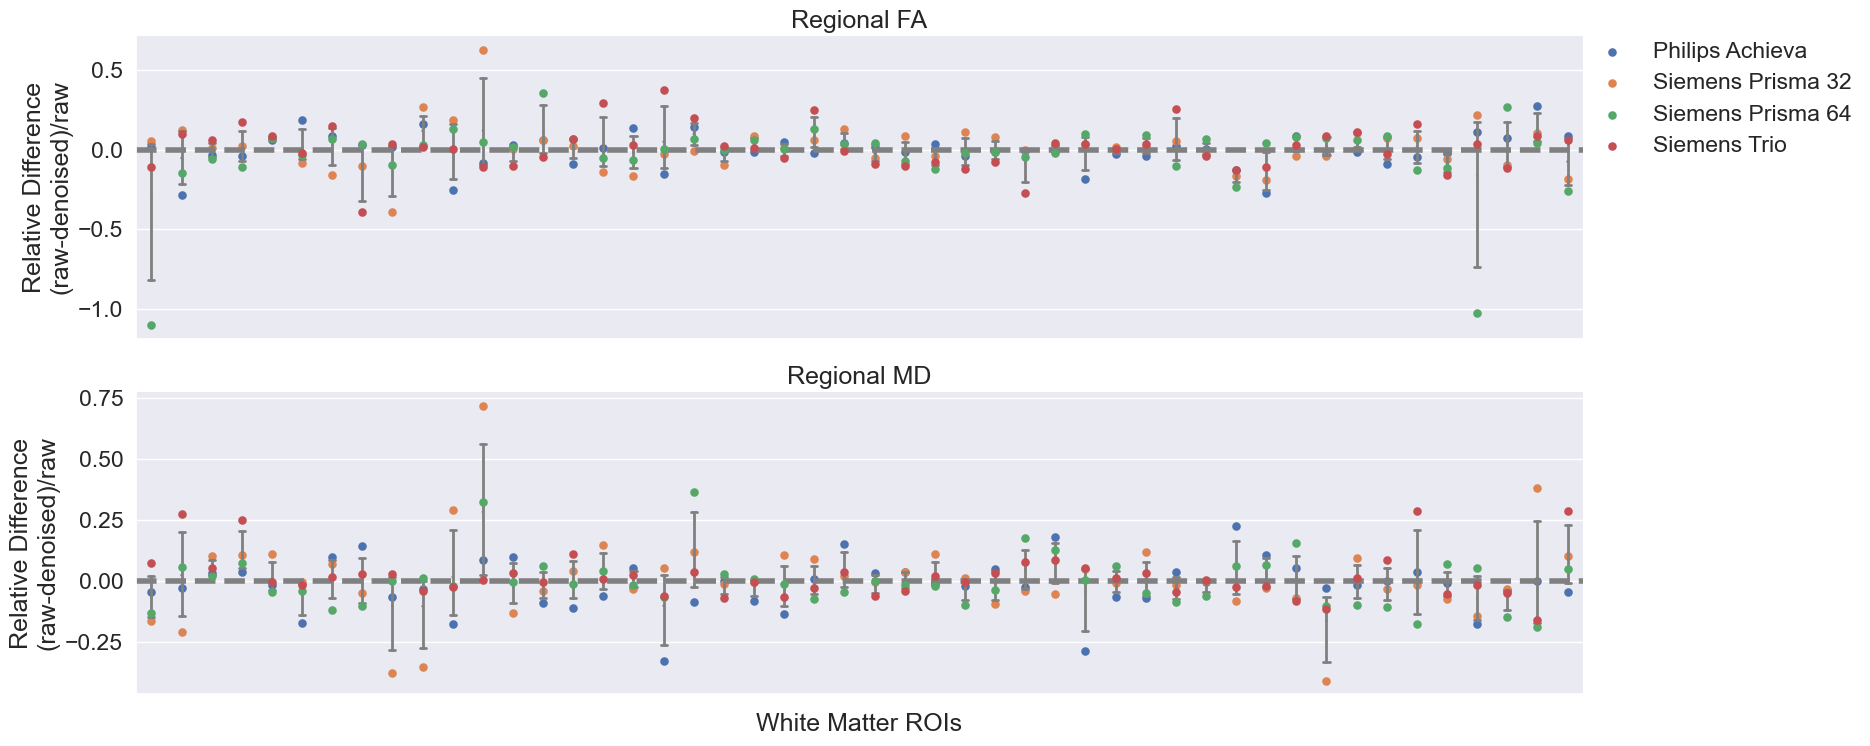

In [15]:
temp_raw = all_stats[all_stats.denoised == 'raw']
temp_denoised = all_stats[all_stats.denoised == 'denoised']
temp_denoised_post_eddy = all_stats[all_stats.denoised == 'denoised_post_eddy']

diff = (temp_raw.value.values - temp_denoised.value.values)/temp_raw.value.values

reldiff = pd.DataFrame({"IDP": temp_raw.IDP, "IDP_type": temp_raw.IDP_type, "scanner": temp_raw.scanner, 
                        "variable":  temp_raw.variable, "Relative Difference": diff, "denoised": "denoised"})

diff = (temp_raw.value.values - temp_denoised_post_eddy.value.values)/temp_raw.value.values
reldiff = pd.concat((reldiff,
    pd.DataFrame({"IDP": temp_raw.IDP, "IDP_type": temp_raw.IDP_type, "scanner": temp_raw.scanner, 
                        "variable":  temp_raw.variable, "Relative Difference": diff, "denoised": "denoised_post_eddy"})
                   ))
reldiff['IDPno'] = [i.split('_')[3] for i in reldiff.IDP]

sns.set(font_scale = 1.5)
# g = sns.catplot(data=reldiff[(reldiff.variable == 'CoV') & (reldiff.denoised == 'denoised')], 
#                     x="IDPno", y='Relative Difference', #hue="denoised",
#                    row='IDP_type', join=False, capsize=.4, scale = 0.7, errwidth=2,
#                    sharex=True, sharey=False, height=4, aspect=4, kind='point')


reldiff.insert(1, 'scanner_name', reldiff['scanner'].map(scanner_dict))
g = sns.catplot(data=reldiff[(reldiff.variable == 'CoV') & (reldiff.denoised == 'denoised')], 
                    x='IDPno', y='Relative Difference', hue="scanner_name",
                   row='IDP_type', join=False, capsize=.4, scale = 0.7, errwidth=2,
                   sharex=True, sharey=False, height=4, aspect=4, kind='point', legend=False)
g.map(sns.pointplot, 'IDPno', 'Relative Difference', 
      join=False, capsize=.2, scale = 0.2, errwidth=2, color='grey', legend=False)


g.axes[0][0].axhline(y=0, ls='--', c='.5', lw=4);
g.axes[1][0].axhline(y=0, ls='--', c='.5', lw=4);

g.axes[0][0].legend(frameon=False, loc='upper left', bbox_to_anchor=(0.99, 1.05)) 

g.set_xlabels('White Matter ROIs', size=18);#, rotation=90);
g.set_ylabels('Relative Difference\n(raw-denoised)/raw', size=18)
g.set_xticklabels('');

axes = g.axes.flatten()
axes[0].set_title("Regional FA")
axes[1].set_title("Regional MD")

plt.savefig(f'{fig_out}/denoise_IDPwise.png', dpi=500, bbox_inches='tight')
plt.show()

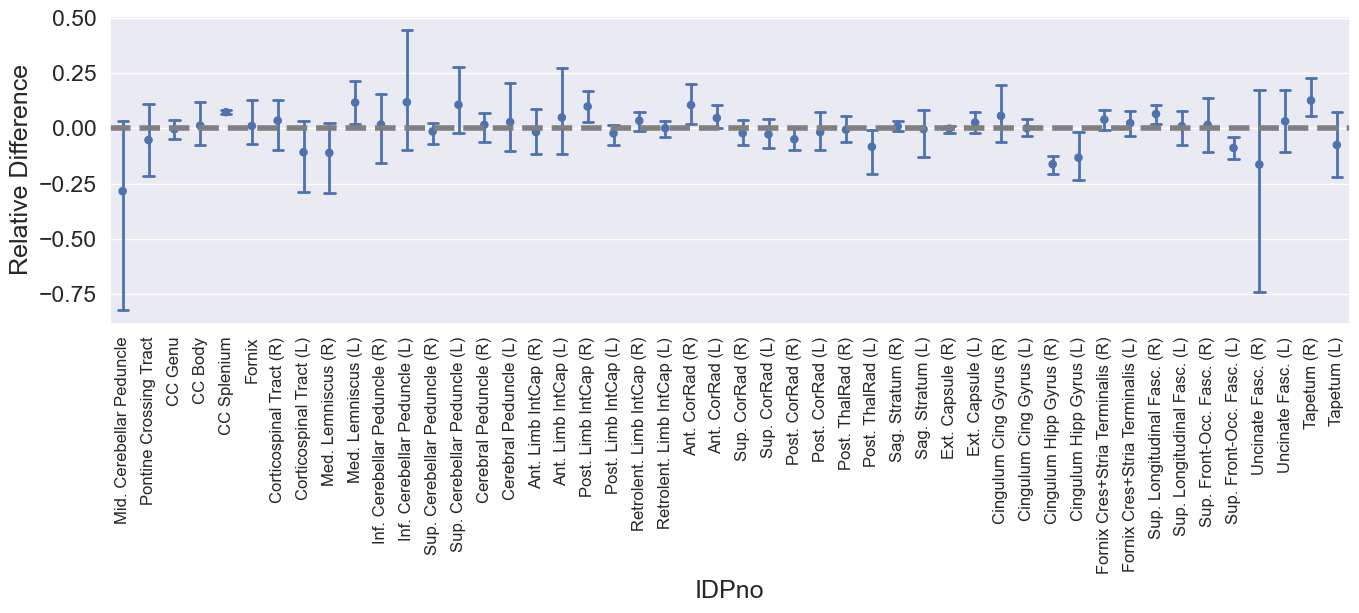

In [16]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(16, 4))

g = sns.pointplot(data=reldiff[(reldiff.variable == 'CoV') & (reldiff.denoised == 'denoised') & (reldiff.IDP_type == 'TBSS_FA')], 
                  x='IDPno', y='Relative Difference', 
                  join=False, capsize=.4, scale = 0.7, errwidth=2)

plt.axhline(y=0, ls='--', c='.5', lw=4);

labels = ['Mid. Cerebellar Peduncle', 'Pontine Crossing Tract', 'CC Genu', 'CC Body', 'CC Splenium', 'Fornix',
         'Corticospinal Tract (R)', 'Corticospinal Tract (L)', 'Med. Lemniscus (R)', 'Med. Lemniscus (L)',
         'Inf. Cerebellar Peduncle (R)', 'Inf. Cerebellar Peduncle (L)', 'Sup. Cerebellar Peduncle (R)', 
          'Sup. Cerebellar Peduncle (L)', 'Cerebral Peduncle (R)', 'Cerebral Peduncle (L)',
          'Ant. Limb IntCap (R)', 'Ant. Limb IntCap (L)', 'Post. Limb IntCap (R)', 'Post. Limb IntCap (L)',
          'Retrolent. Limb IntCap (R)', 'Retrolent. Limb IntCap (L)', 'Ant. CorRad (R)', 'Ant. CorRad (L)',
          'Sup. CorRad (R)', 'Sup. CorRad (L)', 'Post. CorRad (R)', 'Post. CorRad (L)', 'Post. ThalRad (R)',
          'Post. ThalRad (L)', 'Sag. Stratum (R)', 'Sag. Stratum (L)', 'Ext. Capsule (R)', 'Ext. Capsule (L)',
          'Cingulum Cing Gyrus (R)', 'Cingulum Cing Gyrus (L)', 'Cingulum Hipp Gyrus (R)', 'Cingulum Hipp Gyrus (L)',
          'Fornix Cres+Stria Terminalis (R)', 'Fornix Cres+Stria Terminalis (L)', 'Sup. Longitudinal Fasc. (R)', 
          'Sup. Longitudinal Fasc. (L)', 'Sup. Front-Occ. Fasc. (R)', 'Sup. Front-Occ. Fasc. (L)', 'Uncinate Fasc. (R)', 
          'Uncinate Fasc. (L)', 'Tapetum (R)', 'Tapetum (L)'
         ]
g.set_xticklabels(labels, fontsize=12, rotation=90);

plt.show()

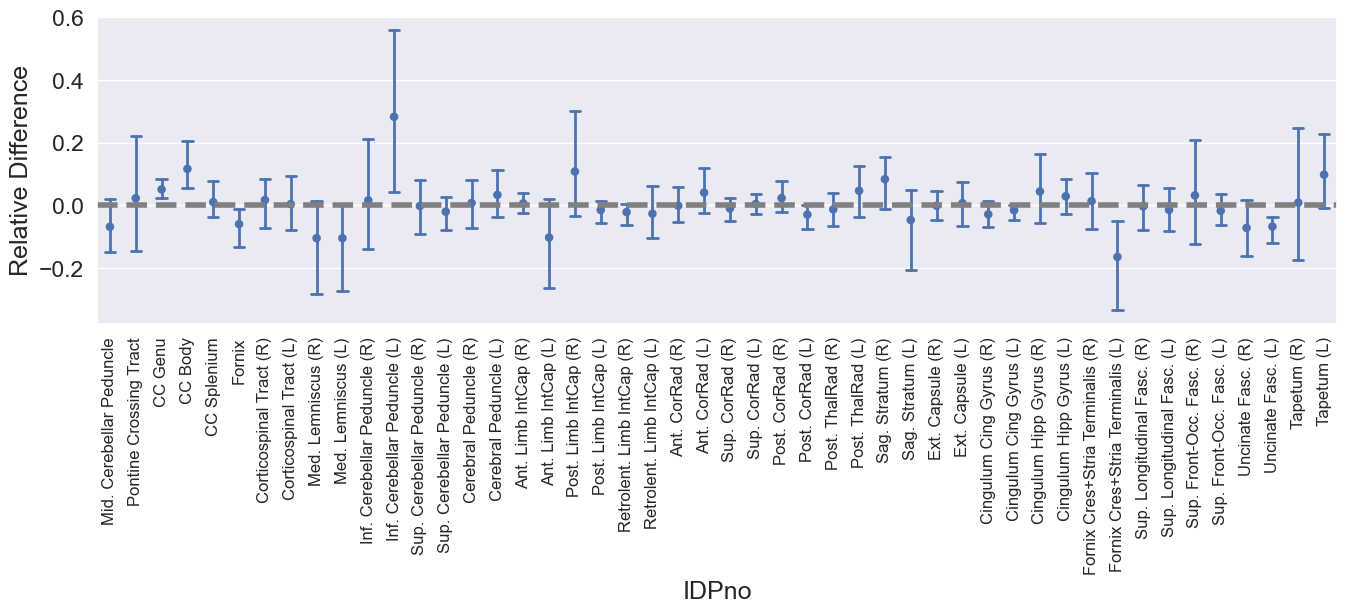

In [17]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(16, 4))
 
g = sns.pointplot(data=reldiff[(reldiff.variable == 'CoV') & (reldiff.denoised == 'denoised') & (reldiff.IDP_type == 'TBSS_MD')], 
                  x='IDPno', y='Relative Difference', 
                  join=False, capsize=.4, scale = 0.7, errwidth=2)

plt.axhline(y=0, ls='--', c='.5', lw=4);

labels = ['Mid. Cerebellar Peduncle', 'Pontine Crossing Tract', 'CC Genu', 'CC Body', 'CC Splenium', 'Fornix',
         'Corticospinal Tract (R)', 'Corticospinal Tract (L)', 'Med. Lemniscus (R)', 'Med. Lemniscus (L)',
         'Inf. Cerebellar Peduncle (R)', 'Inf. Cerebellar Peduncle (L)', 'Sup. Cerebellar Peduncle (R)', 
          'Sup. Cerebellar Peduncle (L)', 'Cerebral Peduncle (R)', 'Cerebral Peduncle (L)',
          'Ant. Limb IntCap (R)', 'Ant. Limb IntCap (L)', 'Post. Limb IntCap (R)', 'Post. Limb IntCap (L)',
          'Retrolent. Limb IntCap (R)', 'Retrolent. Limb IntCap (L)', 'Ant. CorRad (R)', 'Ant. CorRad (L)',
          'Sup. CorRad (R)', 'Sup. CorRad (L)', 'Post. CorRad (R)', 'Post. CorRad (L)', 'Post. ThalRad (R)',
          'Post. ThalRad (L)', 'Sag. Stratum (R)', 'Sag. Stratum (L)', 'Ext. Capsule (R)', 'Ext. Capsule (L)',
          'Cingulum Cing Gyrus (R)', 'Cingulum Cing Gyrus (L)', 'Cingulum Hipp Gyrus (R)', 'Cingulum Hipp Gyrus (L)',
          'Fornix Cres+Stria Terminalis (R)', 'Fornix Cres+Stria Terminalis (L)', 'Sup. Longitudinal Fasc. (R)', 
          'Sup. Longitudinal Fasc. (L)', 'Sup. Front-Occ. Fasc. (R)', 'Sup. Front-Occ. Fasc. (L)', 'Uncinate Fasc. (R)', 
          'Uncinate Fasc. (L)', 'Tapetum (R)', 'Tapetum (L)'
         ]
g.set_xticklabels(labels, fontsize=12, rotation=90);

plt.show()

### How does the region-wise relative difference vary with distortion?

In [18]:
# Load TBSS distortion values - 1 txt file per sessions for all repeat sessions (only the raw)
idp_files = glob.glob(f'{studydir}/data/fieldmap_TBSS/*.txt')
dist_df = [pd.read_csv(f, sep="\t", index_col=None, header=None).T for f in idp_files]
dist_df = pd.concat(dist_df, ignore_index=True)

# add hdr and session info
idp_hdrs = list(df.filter(regex='dMRI_TBSS_FA').columns.values)
colnames = [i.replace('FA', 'distortion') for i in idp_hdrs if 'TBSS_FA' in i]
dist_df.columns = colnames
dist_df.insert(0, "session", [i.split('_TBSS/')[1].split('.txt')[0] for i in idp_files])

# merge into subset of main dataframe for easy info
dist_df = pd.merge(df[df.denoised == 'raw'][basic_info_hdrs], dist_df, 'left')


In [19]:
# get scanner averaged distortion
idp_hdrs = list(dist_df.filter(regex='dMRI_TBSS').columns.values)

dist_all_stats = pd.DataFrame()
for s in ["NOT1ACH", "OXF1PRI", "OXF2PRI", "OXF3TRI"]:
    tempdf = dist_df[dist_df.scanner_typeloc == s][idp_hdrs]
    mn, med, mad, cv, mad_med = get_stats(tempdf)
    temp = pd.DataFrame({"IDP": cv.index, "Mean": mn, "scanner": s})

    dist_all_stats = pd.concat((dist_all_stats, temp))

In [20]:
# merge on scanner specific regions
temp = reldiff[(reldiff.variable == 'CoV') & (reldiff.IDP_type == 'TBSS_FA') & (reldiff.denoised == 'denoised')].copy()
temp.reset_index(drop=True, inplace=True)
temp['Mean Off-reson Freq'] = dist_all_stats.Mean.values

plotdf = reldiff[(reldiff.variable == 'CoV') & (reldiff.IDP_type == 'TBSS_MD') & (reldiff.denoised == 'denoised')].copy()
plotdf.reset_index(drop=True, inplace=True)
plotdf['Mean Off-reson Freq'] = dist_all_stats.Mean.values

plotdf = pd.concat((plotdf, temp))

# add TBSS descriptions
def lines_that_contain(s, fp):
    with open(fp, "r") as fp:
        l = [line for line in fp if s in line]
        l = l[0].split('" ')[1]
        l = l.split('\\')[0]
        return l
    
fp = f'{studydir}/data/list.txt'
plotdf['IDPdesc'] = [lines_that_contain(s, fp) for s in plotdf.IDP]

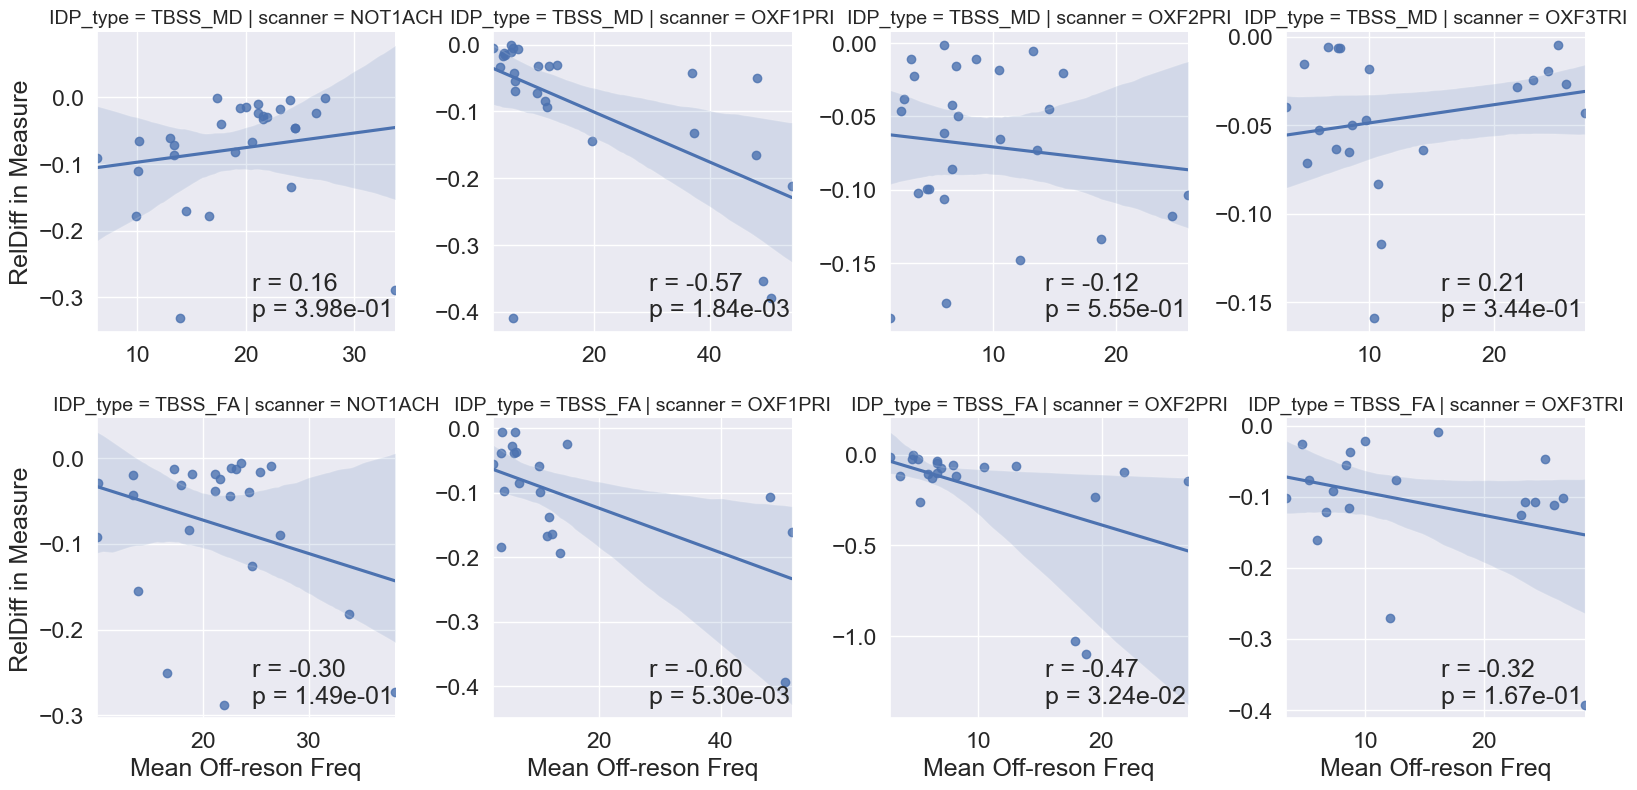

In [21]:
g = sns.lmplot(data=plotdf[(plotdf['Relative Difference'] < 0)], x='Mean Off-reson Freq', y='Relative Difference', col='scanner', row='IDP_type',
           height=4, aspect=1, sharex=False, sharey=False)

import scipy as sp
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Mean Off-reson Freq'], data['Relative Difference'])
    ax = plt.gca()
    ax.text(.52, .05, 'r = {:.2f}\np = {:.2e}'.format(r, p),
            transform=ax.transAxes)
    return data
    
data = g.map_dataframe(annotate)
g.set_ylabels('RelDiff in Measure');
g.set_xlabels('Mean Off-reson Freq');
g.set_titles(size=14);

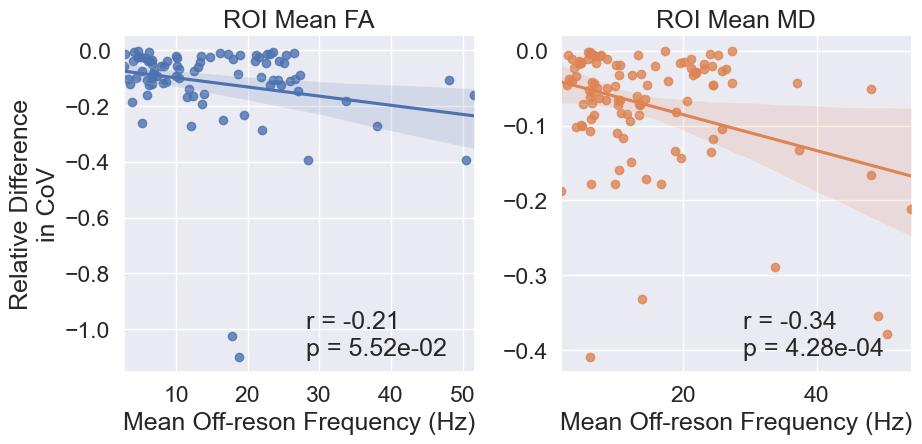

In [22]:
# Plot all data points (across all scanners)
sns.set(font_scale = 1.5)

plotdf.replace({'TBSS_MD':'ROI Mean MD', 'TBSS_FA':'ROI Mean FA'}, inplace=True)

g = sns.lmplot(data=plotdf[(plotdf['Relative Difference'] < 0)], x='Mean Off-reson Freq', y='Relative Difference', 
               col='IDP_type', col_order=['ROI Mean FA', 'ROI Mean MD'], 
               hue='IDP_type', hue_order=['ROI Mean FA', 'ROI Mean MD'], 
               height=4.5, aspect=1, sharex=False, sharey=False)
    
data = g.map_dataframe(annotate)
g.set_ylabels('Relative Difference\nin CoV', size=18);
g.set_xlabels('Mean Off-reson Frequency (Hz)', size=18);
g.set_titles(col_template="{col_name}", size=18);

plt.savefig(f'{fig_out}/denoise_vs_offres.png', dpi=500, bbox_inches='tight')


In [23]:
# merge on scanner specific regions
temp = reldiff[(reldiff.variable == 'CoV') & (reldiff.IDP_type == 'TBSS_FA') & (reldiff.denoised == 'denoised_post_eddy')].copy()
temp.reset_index(drop=True, inplace=True)
temp['Mean Off-reson Freq'] = dist_all_stats.Mean.values

plotdf = reldiff[(reldiff.variable == 'CoV') & (reldiff.IDP_type == 'TBSS_MD') & (reldiff.denoised == 'denoised_post_eddy')].copy()
plotdf.reset_index(drop=True, inplace=True)
plotdf['Mean Off-reson Freq'] = dist_all_stats.Mean.values

plotdf = pd.concat((plotdf, temp))

# add TBSS descriptions
def lines_that_contain(s, fp):
    with open(fp, "r") as fp:
        l = [line for line in fp if s in line]
        l = l[0].split('" ')[1]
        l = l.split('\\')[0]
        return l
    
fp = f'{studydir}/data/list.txt'
plotdf['IDPdesc'] = [lines_that_contain(s, fp) for s in plotdf.IDP]

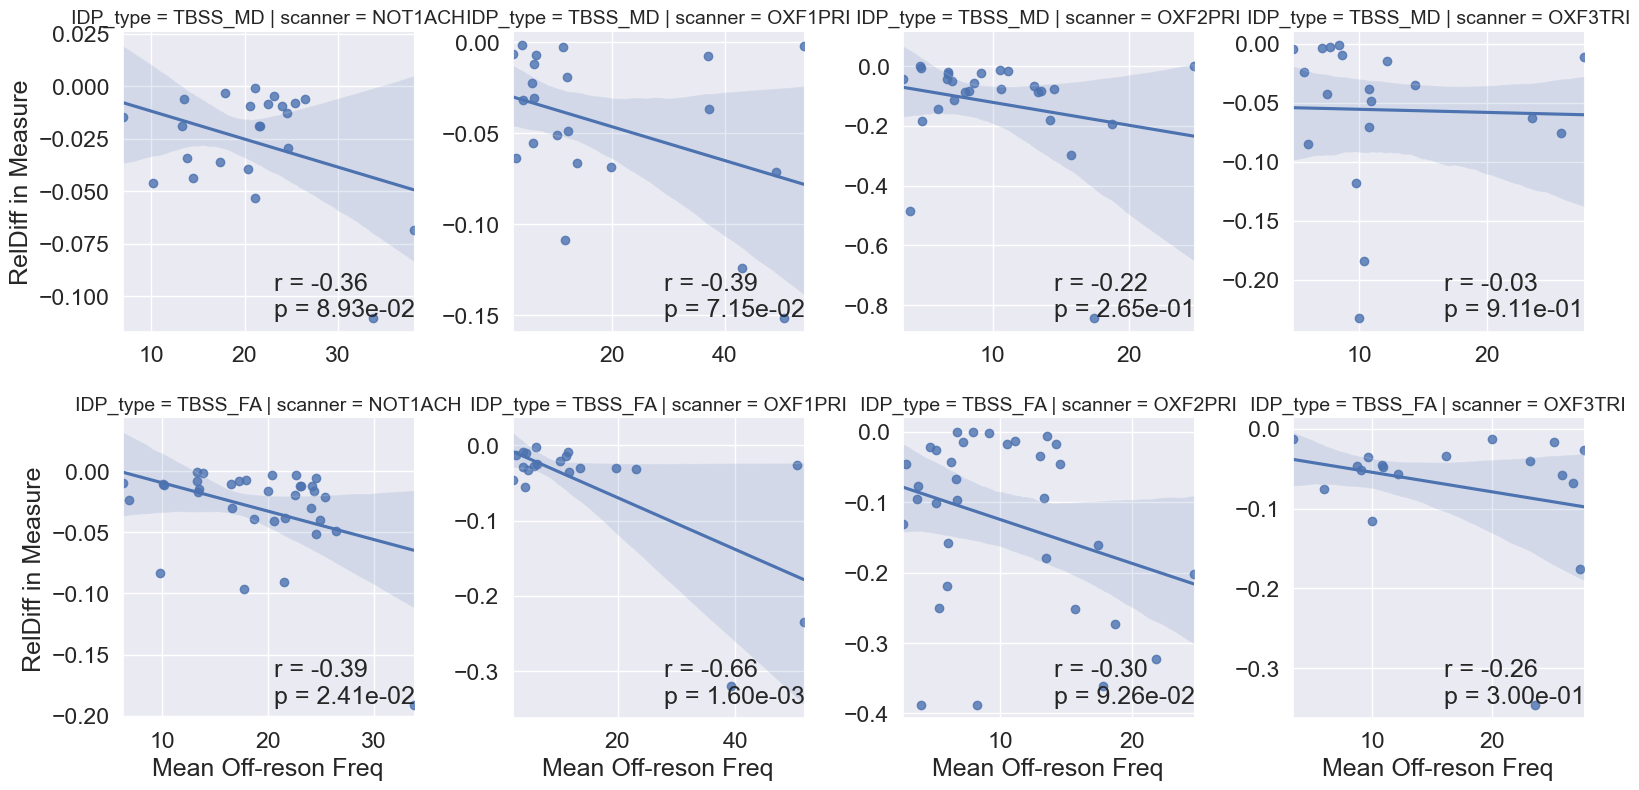

In [24]:
g = sns.lmplot(data=plotdf[(plotdf['Relative Difference'] < 0)], x='Mean Off-reson Freq', y='Relative Difference', col='scanner', row='IDP_type',
           height=4, aspect=1, sharex=False, sharey=False)

import scipy as sp
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Mean Off-reson Freq'], data['Relative Difference'])
    ax = plt.gca()
    ax.text(.52, .05, 'r = {:.2f}\np = {:.2e}'.format(r, p),
            transform=ax.transAxes)
    return data
    
data = g.map_dataframe(annotate)
g.set_ylabels('RelDiff in Measure');
g.set_xlabels('Mean Off-reson Freq');
g.set_titles(size=14);

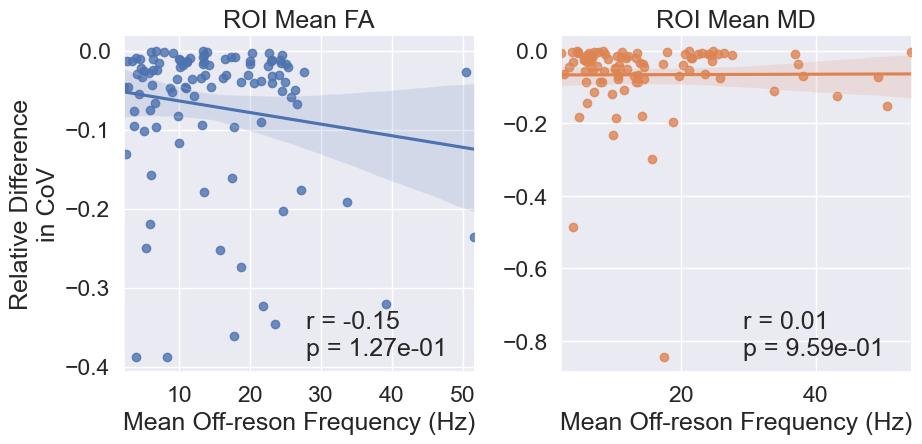

In [25]:
# Plot all data points (across all scanners)
sns.set(font_scale = 1.5)

plotdf.replace({'TBSS_MD':'ROI Mean MD', 'TBSS_FA':'ROI Mean FA'}, inplace=True)

g = sns.lmplot(data=plotdf[(plotdf['Relative Difference'] < 0)], x='Mean Off-reson Freq', y='Relative Difference', 
               col='IDP_type', col_order=['ROI Mean FA', 'ROI Mean MD'], 
               hue='IDP_type', hue_order=['ROI Mean FA', 'ROI Mean MD'], 
               height=4.5, aspect=1, sharex=False, sharey=False)
    
data = g.map_dataframe(annotate)
g.set_ylabels('Relative Difference\nin CoV', size=18);
g.set_xlabels('Mean Off-reson Frequency (Hz)', size=18);
g.set_titles(col_template="{col_name}", size=18);

plt.savefig(f'{fig_out}/denoise_vs_offres_denoise_post.png', dpi=500, bbox_inches='tight')
